# Importar dados e pacotes essenciais

In [58]:
#%pip install dython

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from dython import nominal
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler, StandardScaler

pd.set_option('display.max_columns', None)

In [60]:
df1 = pd.read_csv("data/new_df1.csv")
df2 = pd.read_csv("data/new_df2.csv")

# Criação de novas variáveis

In [61]:
df1.head(1)

,gender,approv_in_adv,loan_type,loan_purpose,business_or_commercial,loan_amount,rate_of_interest,upfront_charges,term,property_value,construction_type,income,credit_type,credit_score,age,ltv,region,status,outlier_income,miss_rate_of_interest,miss_upfront_charges,miss_property_value,miss_income,miss_ltv,miss_approv_in_adv,miss_loan_purpose,miss_age
0,Sex Not Available,nopre,type1,p4,nob/c,216500,2.99,5548.89,180.0,308000.0,sb,4440.0,CRIF,768,25-34,70.292208,south,0,0,0,0,0,0,0,0,0,0


***Algumas observações:***
- em secções anteriores já criamos novas variáveis, tal como flags de existencia de missing values ou a flag the existencia de outliers;
- nesta secção iremos criar mais informações que possam ser relevantes ao negócio;
- é também importante dar visibilidade de possíveis variáveis que podiam ser interessantes mais que não temos acesso no momento!

In [62]:
df1['ratio_upfrontcharges_loanamount'] = df1['upfront_charges']/df1['loan_amount']*100
df2['ratio_upfrontcharges_loanamount'] = df2['upfront_charges']/df2['loan_amount']*100

In [63]:
df1['ratio_income_loanamount'] = df1['income']/df1['loan_amount']*100
df2['ratio_income_loanamount'] = df2['income']/df2['loan_amount']*100

In [64]:
df1['paid_in_adv'] = df1.property_value - df1.loan_amount

# Correlações

In [65]:
%%time
corr = nominal.associations(df1, compute_only = True)

/home/diego/Documentos/.venv/lib/python3.11/site-packages/dython/nominal.py:736: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
/home/diego/Documentos/.venv/lib/python3.11/site-packages/dython/nominal.py:737: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)
/home/diego/Documentos/.venv/lib/python3.11/site-packages/dython/nominal.py:736: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compati

CPU times: user 12.5 s, sys: 5.76 s, total: 18.3 s
Wall time: 10.4 s


In [66]:
corr_matrix = corr['corr']

In [67]:
def plot_heatmap(data, title, fig_size=(12, 10)):
    """
    data: dataframe to get heatmap
    title: title of the plot
    fig_size: size of the figure
    output: heatmap
    """
    plt.figure(figsize = fig_size)
    plt.title(title, fontsize=20)

    sns.heatmap(data, 
                cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
                annot=True, annot_kws={"size": 8}, square=True)

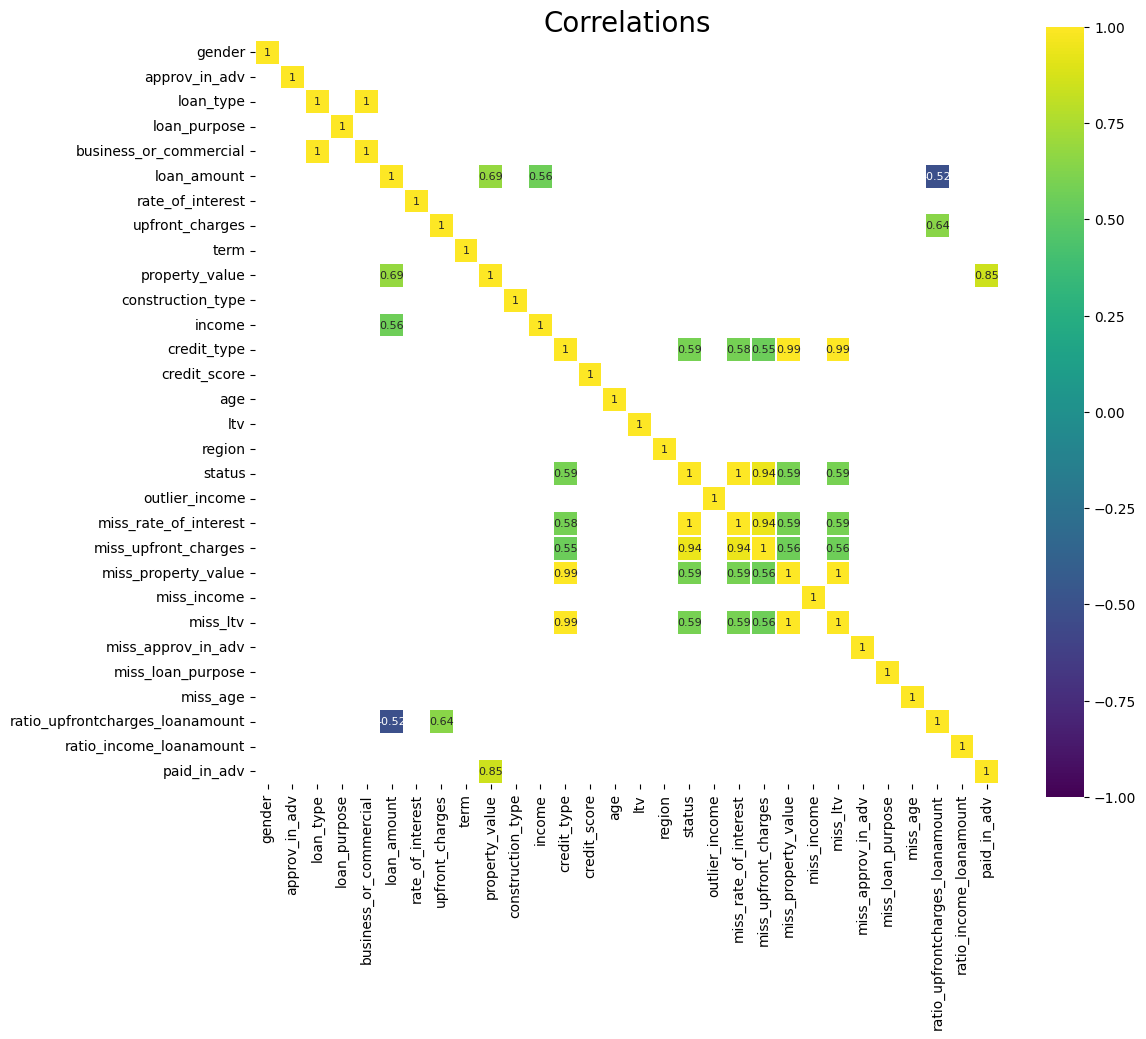

In [68]:
plot_heatmap(corr_matrix[(corr_matrix >= 0.5) | (corr_matrix <= -0.5)], "Correlations")

In [69]:
def get_cor_features(corr_matrix, lim_inf = -0.5, lim_sup = 0.5, round_values = 4):
    """
    corr_matrix: dataframe with correlations
    lim_inf: see correlations <= this number
    lim_sup: see correlations >= this number
    round_values: see correlations rounded to this value
    output: list with correlated variables and correlation value
    """
    correlated = []

    for i in range(0,len(corr_matrix)):
            for j in range(i,len(corr_matrix)):
                if i == j:
                    pass
                else:
                    if (corr_matrix[corr_matrix.index[j]][corr_matrix.columns[i]] >= lim_sup) | (corr_matrix[corr_matrix.index[j]][corr_matrix.columns[i]] <= lim_inf):
                        correlated.append([corr_matrix.index[j],corr_matrix.columns[i], round(corr_matrix[corr_matrix.index[j]][corr_matrix.columns[i]], round_values)])
                    else:
                        pass
    return correlated

In [70]:
get_cor_features(corr_matrix)

[['business_or_commercial', 'loan_type', 1.0],
 ['property_value', 'loan_amount', 0.6866],
 ['income', 'loan_amount', 0.5576],
 ['ratio_upfrontcharges_loanamount', 'loan_amount', -0.5155],
 ['ratio_upfrontcharges_loanamount', 'upfront_charges', 0.6409],
 ['paid_in_adv', 'property_value', 0.8451],
 ['status', 'credit_type', 0.5912],
 ['miss_rate_of_interest', 'credit_type', 0.5831],
 ['miss_upfront_charges', 'credit_type', 0.5525],
 ['miss_property_value', 'credit_type', 0.9926],
 ['miss_ltv', 'credit_type', 0.9926],
 ['miss_rate_of_interest', 'status', 0.9964],
 ['miss_upfront_charges', 'status', 0.9421],
 ['miss_property_value', 'status', 0.5868],
 ['miss_ltv', 'status', 0.5868],
 ['miss_upfront_charges', 'miss_rate_of_interest', 0.9441],
 ['miss_property_value', 'miss_rate_of_interest', 0.5889],
 ['miss_ltv', 'miss_rate_of_interest', 0.5889],
 ['miss_property_value', 'miss_upfront_charges', 0.5561],
 ['miss_ltv', 'miss_upfront_charges', 0.5561],
 ['miss_ltv', 'miss_property_value', 1

In [71]:
# remover algumas variáveis muito correlacionadas
to_drop = ['business_or_commercial', 'credit_type', 'miss_property_value',
          'miss_upfront_charges']

df1.drop(columns=to_drop, inplace=True)
df2.drop(columns=to_drop, inplace=True)

# Discretização de variáveis numéricas

## bins com mesmo tamanho

In [72]:
variaveis_para_discretizar = ['loan_amount','income']
disc_width = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
disc_width.fit(df1[variaveis_para_discretizar])

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')

In [73]:
#saber quais os pontos de corte
disc_width.bin_edges_

array([array([  16500.,  349500.,  682500., 1015500., 1348500., 1681500.,
              2014500., 2347500., 2680500., 3013500., 3346500.])         ,
       array([    0.,  2292.,  4584.,  6876.,  9168., 11460., 13752., 16044.,
              18336., 20628., 22920.])                                       ],
      dtype=object)

In [74]:
#aplicar discretização à df1
disc_data1 = pd.DataFrame(disc_width.transform(df1[variaveis_para_discretizar]), columns = variaveis_para_discretizar)

In [75]:
# será que faz sentido manter estas categorias?
disc_data1.loan_amount.value_counts(normalize=True) 

loan_amount
0.0    0.608125
1.0    0.352151
2.0    0.034900
3.0    0.003229
4.0    0.001028
5.0    0.000336
6.0    0.000115
8.0    0.000058
7.0    0.000048
9.0    0.000010
Name: proportion, dtype: float64

In [76]:
#agrupamento
disc_data1.loc[disc_data1.loan_amount>=3, 'loan_amount'] = 3

In [77]:
disc_data1.loan_amount.value_counts(normalize=True) 

loan_amount
0.0    0.608125
1.0    0.352151
2.0    0.034900
3.0    0.004824
Name: proportion, dtype: float64

In [78]:
#aplicar discretização à df2
disc_data2 = pd.DataFrame(disc_width.transform(df2[variaveis_para_discretizar]), columns = variaveis_para_discretizar)

In [79]:
disc_data2.loan_amount.value_counts(normalize=True)

loan_amount
0.0    0.607610
1.0    0.352234
2.0    0.034865
3.0    0.003543
4.0    0.001121
5.0    0.000404
7.0    0.000090
6.0    0.000090
8.0    0.000022
9.0    0.000022
Name: proportion, dtype: float64

In [80]:
#agrupamento
disc_data2.loc[disc_data2.loan_amount>=3, 'loan_amount'] = 3

In [81]:
disc_data2.loan_amount.value_counts(normalize=True) 

loan_amount
0.0    0.607610
1.0    0.352234
2.0    0.034865
3.0    0.005291
Name: proportion, dtype: float64

## bins com mesmo volume

In [82]:
variaveis_para_discretizar = ['loan_amount','income']
disc_volume = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
disc_volume.fit(df1[variaveis_para_discretizar])

KBinsDiscretizer(encode='ordinal', n_bins=10)

In [83]:
#saber quais os pontos de corte
disc_volume.bin_edges_

array([array([  16500.,  126500.,  176500.,  216500.,  256500.,  296500.,
               346500.,  406500.,  466500.,  566500., 3346500.])         ,
       array([    0.,  2580.,  3420.,  4260.,  5100.,  5700.,  6420.,  7560.,
               9120., 11880., 22920.])                                       ],
      dtype=object)

In [84]:
#aplicar discretização à df1
disc_data1 = pd.DataFrame(disc_volume.transform(df1[variaveis_para_discretizar]), columns = variaveis_para_discretizar)

In [85]:
disc_data1.loan_amount.value_counts()

loan_amount
1.0    11273
9.0    11112
8.0    11000
5.0    10877
6.0    10854
3.0    10336
4.0    10124
2.0    10089
7.0     9707
0.0     8697
Name: count, dtype: int64

In [86]:
#aplicar discretização à df2
disc_data2 = pd.DataFrame(disc_volume.transform(df2[variaveis_para_discretizar]), columns = variaveis_para_discretizar)

In [87]:
disc_data2.loan_amount.value_counts()

loan_amount
1.0    4815
9.0    4796
8.0    4711
6.0    4654
5.0    4648
3.0    4479
2.0    4346
4.0    4291
7.0    4145
0.0    3716
Name: count, dtype: int64

# Encodings de variáveis categóricas

- antes de fazer o enconding faz sentido verificarmos quantas categorias temos e qual a sua percentagem

In [88]:
for col in df1.select_dtypes('object').columns:
    print(col, ': \n', df1[col].value_counts(dropna=False, normalize=True)*100)
    print('\n')

gender : 
 gender
Male                 28.442668
Joint                27.867088
Sex Not Available    25.270734
Female               18.419510
Name: proportion, dtype: float64


approv_in_adv : 
 approv_in_adv
nopre    84.416109
pre      15.583891
Name: proportion, dtype: float64


loan_type : 
 loan_type
type1    76.111042
type2    13.951321
type3     9.937638
Name: proportion, dtype: float64


loan_purpose : 
 loan_purpose
p3    37.529908
p4    37.063871
p1    23.219210
p2     2.187011
Name: proportion, dtype: float64


construction_type : 
 construction_type
sb    99.975977
mh     0.024023
Name: proportion, dtype: float64


age : 
 age
45-54    23.589157
35-44    22.096878
55-64    21.832630
65-74    13.860996
25-34    12.889525
>74       4.848706
<25       0.882107
Name: proportion, dtype: float64


region : 
 region
North         50.263767
south         43.030105
central        5.871105
North-East     0.835023
Name: proportion, dtype: float64




In [89]:
variaveis_para_encode = ['gender', 'loan_type']
enc_oh = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc_oh.fit(df1[variaveis_para_encode])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [90]:
enc_oh.categories_

[array(['Female', 'Joint', 'Male', 'Sex Not Available'], dtype=object),
 array(['type1', 'type2', 'type3'], dtype=object)]

In [91]:
enc_oh.feature_names_in_

array(['gender', 'loan_type'], dtype=object)

In [92]:
df1[variaveis_para_encode].head()

,gender,loan_type
0,Sex Not Available,type1
1,Joint,type1
2,Joint,type1
3,Joint,type1
4,Joint,type1


In [93]:
#aplicar discretização à df1
enc_data1 = pd.DataFrame(enc_oh.transform(df1[variaveis_para_encode]))

In [94]:
enc_data1.head()

,0,1,2,3,4,5,6
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [95]:
#aplicar discretização à df2
enc_data2 = pd.DataFrame(enc_oh.transform(df2[variaveis_para_encode]))

In [96]:
enc_data2.head()

,0,1,2,3,4,5,6
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Escalonamento dos dados

Para exercicio vamos criar uma dataframe com variáveis da df1, disc_data1 e enc_data1

In [97]:
nova_df1 = pd.concat([df1[['ratio_income_loanamount', 'credit_score']].reset_index(drop=True), disc_data1, enc_data1], axis=1)

In [98]:
nova_df1

,ratio_income_loanamount,credit_score,loan_amount,income,0,1,2,3,4,5,6
0,2.050808,768,3.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,3.115619,620,3.0,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,5.549770,585,5.0,9.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,5.565684,788,2.0,8.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.955272,751,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
104064,1.190349,866,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
104065,0.774869,702,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
104066,1.597734,613,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
104067,2.834437,573,3.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [99]:
#mesma estrategia para dados df2
nova_df2 = pd.concat([df2[['ratio_income_loanamount', 'credit_score']].reset_index(drop=True), disc_data2, enc_data2], axis=1)

In [101]:
nova_df1.columns = nova_df1.columns.astype(str)

In [102]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(nova_df1)

MinMaxScaler()

In [103]:
nova_df1_transf = pd.DataFrame(minmax_scaler.transform(nova_df1), columns = nova_df1.columns)

In [104]:
nova_df1_transf.head()

,ratio_income_loanamount,credit_score,loan_amount,income,0,1,2,3,4,5,6
0,0.050554,0.6700,0.333333,0.333333,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.076803,0.3000,0.333333,0.777778,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.136807,0.2125,0.555556,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.137199,0.7200,0.222222,0.888889,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.048199,0.6275,0.111111,0.111111,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [105]:
nova_df1_transf.min()

ratio_income_loanamount    0.0
credit_score               0.0
loan_amount                0.0
income                     0.0
0                          0.0
1                          0.0
2                          0.0
3                          0.0
4                          0.0
5                          0.0
6                          0.0
dtype: float64

In [106]:
#É sempre possível reverter o scaling
minmax_scaler.inverse_transform(nova_df1_transf)[0]

array([  2.05080831, 768.        ,   3.        ,   3.        ,
         0.        ,   0.        ,   0.        ,   1.        ,
         1.        ,   0.        ,   0.        ])

In [107]:
#Confirmação...
nova_df1.head(1)

,ratio_income_loanamount,credit_score,loan_amount,income,0,1,2,3,4,5,6
0,2.050808,768,3.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [109]:
nova_df2.columns = nova_df2.columns.astype(str)

In [110]:
nova_df2_transf = pd.DataFrame(minmax_scaler.transform(nova_df2), columns = nova_df2.columns)

In [111]:
nova_df2_transf.head()

,ratio_income_loanamount,credit_score,loan_amount,income,0,1,2,3,4,5,6
0,0.033030,0.8050,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.100884,0.0075,0.000000,0.222222,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.077954,0.3975,0.444444,0.777778,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.023534,0.2025,0.888889,0.333333,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.026430,0.0275,0.777778,0.333333,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [112]:
nova_df2_transf.max()

ratio_income_loanamount    0.78534
credit_score               1.00000
loan_amount                1.00000
income                     1.00000
0                          1.00000
1                          1.00000
2                          1.00000
3                          1.00000
4                          1.00000
5                          1.00000
6                          1.00000
dtype: float64

In [113]:
stand_scaler = StandardScaler()
stand_scaler.fit(nova_df1)

StandardScaler()

In [114]:
nova_df1_transf = pd.DataFrame(stand_scaler.transform(nova_df1), columns = nova_df1.columns)

In [115]:
nova_df1_transf.mean()

ratio_income_loanamount    8.971482e-17
credit_score              -6.035609e-17
loan_amount               -4.192154e-17
income                    -3.447944e-17
0                         -4.192154e-17
1                          7.237269e-17
2                         -8.124858e-18
3                         -1.379178e-16
4                          4.028291e-17
5                         -4.560845e-17
6                         -4.547189e-17
dtype: float64

In [116]:
nova_df1_transf.std()

ratio_income_loanamount    1.000005
credit_score               1.000005
loan_amount                1.000005
income                     1.000005
0                          1.000005
1                          1.000005
2                          1.000005
3                          1.000005
4                          1.000005
5                          1.000005
6                          1.000005
dtype: float64